In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# # I trained the CNN model in Keras framework already, I am going to build CNN in PyTorch framework to see, could I get better result.
# I will use the same code structure for prepring data in here as in Keras notebook.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,CO2,Occupancy,weekend,tod_sin,tod_cos
0,23.18,27.2720,721.25,1,0,-0.999229,-0.039260
1,23.15,27.2675,714.00,1,0,-0.999229,-0.039260
2,23.15,27.2450,713.50,1,0,-0.999534,-0.030539
3,23.15,27.2000,708.25,1,0,-0.999657,-0.026177
4,23.10,27.2000,704.50,1,0,-0.999762,-0.021815


In [5]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

1
0
5


In [6]:
for df in [df_train, df_test]:
    df.drop_duplicates(inplace=True)

In [7]:
# Preparing data for CNN model,
target = 'Occupancy'
features = ["Temperature", "Humidity", "CO2", "weekend", "tod_sin", "tod_cos"]

X_train = df_train[features].values
y_train = df_train[target].values.astype(int)

X_val = df_val[features].values
y_val = df_val[target].values.astype(int)

X_test = df_test[features].values
y_test = df_test[target].values.astype(int)

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scaling the features, I will fit only the train  DS
# Because the weekend is binary and tod_sin, tod_cos are already normialized, to -1 , 1. So I will Standardize the continuous features.
scaler = StandardScaler()
X_train_scaled[:, 0:3] = scaler.fit_transform(X_train_scaled[:, 0:3])

# transforming val and test DS 
X_val_scaled[:, 0:3] = scaler.transform(X_val_scaled[:, 0:3])
X_test_scaled[:, 0:3]= scaler.transform(X_test_scaled[:, 0:3])

print("Train:", X_train_scaled.shape, y_train.shape)
print("Val:", X_val_scaled.shape, y_val.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

Train: (8117, 6) (8117,)
Val: (2663, 6) (2663,)
Test: (9720, 6) (9720,)


In [8]:
# Checking the weekend and tod_sin, tod_cos. 
print("weekend unique:", np.unique(X_train_scaled[:,3]))
print("tod_sin min/max:", X_train_scaled[:,4].min(), X_train_scaled[:,4].max())
print("tod_cos min/max:", X_train_scaled[:,5].min(), X_train_scaled[:,5].max())

weekend unique: [0. 1.]
tod_sin min/max: -1.0 1.0
tod_cos min/max: -1.0 1.0


In [9]:
# MAKING SEQUENCES:
# The CNN model for time series, needs sequences as input 
# I will create windows of minutes that the model will predict right after the window, the next minute

# Creating function

window_size = 60
step_ahead = 1
def windows_time(X, y, window_size = None, step_ahead = None):
   # I will creaate two lists for storing  features and the target
   # The end should start the a window
   X_windows = []
   y_windows = []
   last_start = len(X) - window_size - step_ahead + 1
   for start in range(last_start):
        end = start + window_size
        X_windows.append(X[start:end])                  
        y_windows.append(y[end + step_ahead - 1])      
   return np.array(X_windows), np.array(y_windows)

  
X_train_window, y_train_window = windows_time(X_train_scaled, y_train, window_size, step_ahead)
X_val_window, y_val_window = windows_time(X_val_scaled, y_val, window_size, step_ahead)
X_test_window, y_test_window = windows_time(X_test_scaled, y_test, window_size, step_ahead)

print("Train windows:", X_train_window.shape, y_train_window.shape)
print("Val windows:", X_val_window.shape,y_val_window.shape)
print("Test windows:", X_test_window.shape, y_test_window.shape)

Train windows: (8057, 60, 6) (8057,)
Val windows: (2603, 60, 6) (2603,)
Test windows: (9660, 60, 6) (9660,)


In [10]:
X_train_tensor = torch.tensor(X_train_window, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_window, dtype=torch.long) 
X_val_tensor = torch.tensor(X_val_window, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_window, dtype=torch.long)
X_test_tensor= torch.tensor(X_test_window, dtype=torch.float32)
y_test_tensor= torch.tensor(y_test_window, dtype=torch.long)

In [11]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# I nned to see shape of one batch
for X_batch, y_batch in train_loader:
    print(f"Batch input shape: {X_batch.shape}") 
    print(f"Batch target shape: {y_batch.shape}")
    break  
# In forward function, I will switch input shape and sequence lemght

Batch input shape: torch.Size([64, 60, 6])
Batch target shape: torch.Size([64])


<h2><center>CNN Architecture<h2>

In [13]:
# I am going to build 1D CNN for time series classification. Same issue here, the imbalanced rate is not same for each DS.
# First I need to create a convolutional block class 
# Second, I am going to create the CNN model. 

In [14]:
class ConnvectionalBlocks(nn.Module):
    def __init__(self, Input_channel, Output_channel, kernel_size=3, dropout_rate=0.15):
        super().__init__()
        # First convolutional layer:
        # the constrcutor will have input channel, output channel, kernel size and dropout rate as parameters.
        self.conv1 = nn.Conv1d(in_channels=Input_channel, out_channels=Output_channel, kernel_size=kernel_size, padding= kernel_size//2)
        # Batch normalization:
        self.bn1 = nn.BatchNorm1d(Output_channel)
        self.drop = nn.Dropout1d(p=dropout_rate)

# Operation function:
 # Extrating the local patters 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop(x)
        return x
    
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional block
        self.conv_block1 = ConnvectionalBlocks(Input_channel=6, Output_channel=16, kernel_size=3, dropout_rate=0.1)
        # Second convolutional block
        self.conv_block2 = ConnvectionalBlocks(Input_channel=16, Output_channel= 16, kernel_size=3, dropout_rate=0.1)
        # Max pooling, to halve the lengh
        self.pool1  = nn.MaxPool1d(kernel_size=1)


        # Third convolutional block
        self.conv_block3 = ConnvectionalBlocks(Input_channel=16, Output_channel=32, kernel_size=3, dropout_rate=0.15)
        # Fourth convolutional block
        self.conv_block4 = ConnvectionalBlocks(Input_channel=32, Output_channel=32, kernel_size=3, dropout_rate=0.15)
        # second Max pooling
        self.pool2  = nn.MaxPool1d(kernel_size=1)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        # Fully connected layer
        self.fc1 = nn.Linear(32, 1)


# Operation function:   
    def forward(self, x):
        x = x.transpose(1, 2).contiguous()

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.pool1(x)

        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.pool2(x)

        x = self.global_avg_pool(x)
        x = x.squeeze(-1)
        logits = self.fc1(x)
        return logits

model = CNNModel().to(device)



# Sources :
# https://medium.com/@ugamakelechi501/building-a-convolutional-neural-network-cnn-from-scratch-with-pytorch-eca3ffdcf2ff
# https://www.dkneup.com/blog/cnn-time-series-forecasting-in-tensorflow-pytorch
# https://medium.com/%40santi.pdp/how-pytorch-transposed-convs1d-work-a7adac63c4a5
# For debugging, I used the Qwen3 Max model. 

In [15]:
y_np = y_train 
class_weights = compute_class_weight('balanced', classes=np.unique(y_np), y=y_np)
one_weight = torch.tensor(class_weights[1], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=one_weight)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.00008)
# If val loss does not improve for 5 epochs, lr is going to be cut by half
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min')
print('Optimizer:', optimizer)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 8e-05
)


In [17]:
epochs = 300
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(1, epochs+1):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)            
        loss = criterion(outputs.squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float() 
        correct += (preds.squeeze() == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    
    val_loss = 0.0
    val_preds = []
    val_targets = []
    model.eval()  
     
    with torch.no_grad():  
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits.squeeze(1), y_batch.float())
            val_loss += loss.item() * X_batch.size(0)


            probs = torch.sigmoid(logits.squeeze(1))
            preds = (probs >= 0.5).to(torch.int64)


            val_preds.extend(preds.tolist())
            val_targets.extend(y_batch.tolist())
    val_loss = val_loss / len(val_dataset)


    
    # Converting predictions and targets to numpy for calculations
    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)
    
    val_prec = precision_score(val_targets, val_preds, pos_label=1.0, zero_division=0)
    learning_rate = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch:2d}/{epochs} - "f"Train Loss: {train_loss:.4f} "f"Val Loss: {val_loss:.4f}, "
          f"Prec: {val_prec:.3f}, "f"Learning Rate: {learning_rate:.6f}")
    

    scheduler.step(val_loss)


    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
if patience_counter >= patience:
    model.load_state_dict(best_model_state)
#Source: https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html


Epoch  1/300 - Train Loss: 0.7366 Val Loss: 0.5306, Prec: 0.737, Learning Rate: 0.000200
Epoch  2/300 - Train Loss: 0.5014 Val Loss: 0.4322, Prec: 0.784, Learning Rate: 0.000200
Epoch  3/300 - Train Loss: 0.4220 Val Loss: 0.3932, Prec: 0.824, Learning Rate: 0.000200
Epoch  4/300 - Train Loss: 0.3628 Val Loss: 0.3493, Prec: 0.847, Learning Rate: 0.000200
Epoch  5/300 - Train Loss: 0.3275 Val Loss: 0.3153, Prec: 0.863, Learning Rate: 0.000200
Epoch  6/300 - Train Loss: 0.2918 Val Loss: 0.2922, Prec: 0.893, Learning Rate: 0.000200
Epoch  7/300 - Train Loss: 0.2698 Val Loss: 0.2675, Prec: 0.907, Learning Rate: 0.000200
Epoch  8/300 - Train Loss: 0.2442 Val Loss: 0.2496, Prec: 0.898, Learning Rate: 0.000200
Epoch  9/300 - Train Loss: 0.2292 Val Loss: 0.2447, Prec: 0.904, Learning Rate: 0.000200
Epoch 10/300 - Train Loss: 0.2148 Val Loss: 0.2223, Prec: 0.868, Learning Rate: 0.000200
Epoch 11/300 - Train Loss: 0.2051 Val Loss: 0.2245, Prec: 0.885, Learning Rate: 0.000200
Epoch 12/300 - Train 

In [23]:
import numpy as np
import torch
from sklearn.metrics import average_precision_score, precision_recall_curve, classification_report, confusion_matrix

@torch.inference_mode()
def predict_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_y = []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb).squeeze(1)              # (B,)
        probs = torch.sigmoid(logits).cpu().numpy() # numpy (B,)
        all_probs.append(probs)
        all_y.append(yb.cpu().numpy())
    return np.concatenate(all_probs), np.concatenate(all_y).astype(int)

# IMPORTANT: set shuffle=False for val/test loaders before doing this
val_probs, val_y = predict_probs(model, val_loader, device)

val_ap = average_precision_score(val_y, val_probs)
p, r, thr = precision_recall_curve(val_y, val_probs)

f1 = (2 * p * r) / (p + r + 1e-12)
best_i = np.argmax(f1[:-1])          # thr has length len(p)-1
best_thr = thr[best_i]

print(f"VAL AP (AUPRC): {val_ap:.4f}")
print(f"Best VAL F1: {f1[best_i]:.4f} at threshold={best_thr:.4f} (P={p[best_i]:.4f}, R={r[best_i]:.4f})")

test_probs, test_y = predict_probs(model, test_loader, device)
test_pred = (test_probs >= best_thr).astype(int)

print("\nTEST confusion matrix (using VAL threshold):")
print(confusion_matrix(test_y, test_pred))

print("\nTEST report (using VAL threshold):")
print(classification_report(test_y, test_pred, target_names=["No Occupancy","Occupancy"], zero_division=0))


VAL AP (AUPRC): 0.9492
Best VAL F1: 0.9405 at threshold=0.6932 (P=0.9048, R=0.9792)

TEST confusion matrix (using VAL threshold):
[[6863  805]
 [ 511 1481]]

TEST report (using VAL threshold):
              precision    recall  f1-score   support

No Occupancy       0.93      0.90      0.91      7668
   Occupancy       0.65      0.74      0.69      1992

    accuracy                           0.86      9660
   macro avg       0.79      0.82      0.80      9660
weighted avg       0.87      0.86      0.87      9660



In [18]:
# Evaluation
model.eval()
test_preds = []
test_targets = []
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = criterion(logits.squeeze(), y_batch.float())
        probs = torch.sigmoid(logits.squeeze())
        preds = (probs >= 0.5).to(torch.int64)
        test_loss += loss.item() * X_batch.size(0)

        test_preds.extend(preds.tolist())
        test_targets.extend(y_batch.tolist())
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

Confusion Matrix:


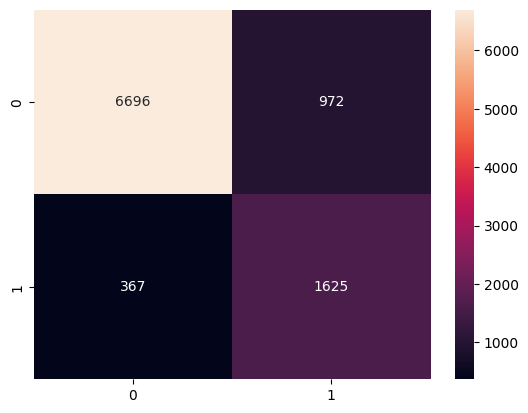

In [19]:
Confusion_matrix = confusion_matrix(test_targets, test_preds)
print("Confusion Matrix:")
sns.heatmap(Confusion_matrix, annot=True, fmt='d')
plt.show()

In [20]:
Classification_report = classification_report(test_targets, test_preds, target_names=['No Occupancy', 'Occupancy'], zero_division=0)
print("Classification Report:\n", Classification_report)

# Even though I have calculated class weights, but still the model is biased towards the class occupancy.
# The gap between traning and validation loss is big, because the distribution of Occupancy is different in each DS.

Classification Report:
               precision    recall  f1-score   support

No Occupancy       0.95      0.87      0.91      7668
   Occupancy       0.63      0.82      0.71      1992

    accuracy                           0.86      9660
   macro avg       0.79      0.84      0.81      9660
weighted avg       0.88      0.86      0.87      9660

